# Part 1
## Tabular Q-learning

### A gridworld environment

In order to build some intuition about RL methods, we are going to begin with a value-based method: Q-learning. To keep things simple we are going to implement Q-learning in its tabular form (i.e. without any function approximation).

The first environment we are going to study is a discrete-space grid-world. We begin by importing all the required python modules.

In [1]:
import numpy as np                                      # numpy is for math operations.
import matplotlib.pyplot as plt                         # matplotlib.pyplot is to make plots.
from envs.environments import grid_world                # The grid_world environment.
from agents.Qlearning import tabular_Qlearning          # The RL agent (tabular Q-learning).
from utilities import plot_policies, plot_trayectory    # Pre-made functions to plot policies and trayectories.
from utilities import print_actions_taken               # Pre-made function to print a log with the actions taken.

Now we create an instance of the environment, which we call "env", and we render the environment to see what we are dealing with.

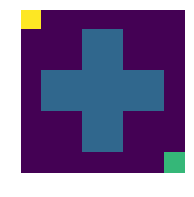

In [2]:
%matplotlib inline

env = grid_world()                  # Creates an environment instance called "env".
env_map = env.get_map()             # Generates an image with the map of the environment.

plt.figure(figsize=(3,3));          # These 3 are matplotplib functions that display the map of the environment.
plt.imshow(env_map);                #
plt.axis('off');                    #

The agent (yellow) is going to be trained to achieve the goal cell (green). The obstacles (blue) are places where the agent cannot move to.

The agent can execute 4 actions: 0-UP, 1-RIGHT, 2-DOWN, 3-LEFT. Each action moves the agent one cell in the corresponding direction. If the agent attemps to move towards an obstacle or a limit of the gridworld, it will remain at its current position.

To interact with the environment object "env", we are going to call the following functions:

### env.step(): 
* **Input:** action. 
* **Output:** next state, reward and done (boolean flag to indicate terminal state). 
* **Function:** move the agent one cell in the direction given by the action (i.e. 0-UP, 1-RIGHT, 2-DOWN, 3-LEFT)

### env.reset():
* **Input:** a boolean flag to start at random positions (optional).
* **Output:** state. 
* **Function:** resets the environment.

### env.render():
* **Input:** none. 
* **Output:** none. 
* **Function:** renders the map of the environment.

As an example, lets run the environment for 100 steps taking random actions.

<IPython.core.display.Javascript object>


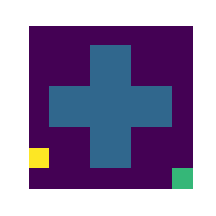

In [3]:
%matplotlib notebook

env = grid_world()                  # Creates an environment instance called "env".
env.reset()                         # Resets the environment.
for i in range(100):
    action = np.random.randint(0,4) # Generates a random int between 0 and 3 (4-1).
    env.step(action)                # Takes the action (moves the agent). 
    env_map = env.render()          # Renders the current map of the environment
    

    
%matplotlib inline

## How to train the agent?

As we mentioned before, the agent (yellow) is going to be trained to acheieve the goal cell (green). To train it we are going to use the tabular version of the Q-learning algorithm:

###  The Q-learning algorithm
![title](imgs/Qlearning.png)


#### A Markov Decision Process

Recall that a Markov Decision Process (MDP) is a tuple of the form: $(S,A,T,R)$, where:
* $S$ denotes the set of states of the environment.
* $A$ denotes the set of actions that the agent can execute.
* $T$ denotes the state-transition probabilities of the environment.
* $R$ denotes the reward function that the agent recieves from the environment.

In our especific example with the grid_world environment:
* $S$ is the set of cells of the grid_world enviroment. In our example $|S|=64$ because the grid_world has dimensions of $8\times8$
* $A$ is the set (0,1,2,3) of actions that the agent can execute (moving up, left, down or right).
* $T$ is the transition function from one cell to another given an action. In our case this is a deterministic function of the environment and is unknown to the agent.
* $R$ is a scalar function that has to reinforce the desired behavior of the agent. We are going to define this function later.


#### The Q-learning algorithm explained

The Q-learning algorithm is an iterative algorithm that seeks to learn the "Quality" function $Q(s,a)$. This function maps tuples $(s,a)$ to a real scalar value (i.e. $S\times A\rightarrow \mathbb{R}$). This value, usually called Q-value, can be seen as the quality of being at a state $s\in S$ and taking an action $a\in A$.

Applying Bellman's principle of optimality, the function Q(s,a) can be recursively expressed as:

\begin{equation}
    Q(s_t,a_t) = r_{t+1} + Q(s_{t+1},a_{t+1})
\end{equation}


### POR COMPLETAR

## The agent class

In order to save some time and focus on the fundamentals of Q-learning, we have already coded an agent class in python.

The agent class initializes a Q-table with $|S|$ rows and $|A|$ columns and all entries in $0$ and has the following methods already implemented:

* greedy(): takes an state as input and returns an action being greedy with the current Q-values.
* epsilon_greedy(): takes an state as input and returns a random action with epsilon probability or a greedy action with (1-epsilon) probability.
* epsilon_decay(): exponentially decays the exploration parameter epsilon (i.e. epsilon = decay$*$epsilon with decay<1)

## Q-learning algorithm (main code)

In [4]:
def run_Qlearning(env,agent,max_episodes,max_steps,exp_decay,start=False,seed=1234):
    np.random.seed(seed)                                           # Fixed random seed for reproducibility.
    policies = []                                                  # Creates an empty python list to save the policies.
    
    for episode in range(max_episodes+1):                          # Iterates over the number of episodes.
        state = env.reset(start)                                   # Resets the environment.
        done = False                                               # The done flag starts as False.
        step = 1                                                   # Step counter starts at 1.
        policies.append(agent.get_policy())                        # Adds current policy to the policies list.
        
        while (not done and step <= max_steps):                    # While loop for current episode.
            action = agent.epsilon_greedy(state)                   # Agent selects an action with epsilon-greedy policy.
            next_state,reward,done = env.step(action)              # Agent takes the selected action.
            agent.train(state,action,next_state,reward,done)       # Agent trains (updates Q-table entry).
            
            state = next_state                                     # Updates the current state.
            step += 1                                              # Increments the step counter in 1.
            
        agent.epsilon_decay(rate=exp_decay,min=0.1)                # Reduces the exploration parameter epsilon.
        
        if(episode%(max_episodes/10)==0):                          # This prints some information of the training process
            print('Episode: ',episode,' Steps: ',step,
                  ' Exploration: ',np.round(agent._epsilon,2))
            
    return policies                                                # The function returns the policies list.

## Implementing the agent.train() function

In order to understand Q-learning, we are going to implement the train function of our tabular_Qlearning agent.

This function performs the update:
\begin{equation}
    Q(s_t,a_t) = Q(s_t,a_t) + \alpha\bigg[r_{t+1} + \gamma\max_{\hat{a}}Q(s_{t+1},\hat{a}) - Q(s_t,a_t) \bigg]  
\end{equation}

To implement only this function we are going to create an instance of the tabular_Qlearning class and override the train method.

In [5]:
class our_Qlearning(tabular_Qlearning):          # This is a subclass of tabular_Qlearning and is called: our_Qlearning.
    
    def train(self,state,action,next_state,reward,done):  # Takes as input: state, action, next_state, reward, and done.
        if (not done):                                    # If the next_state is not a terminal state.
            BE = reward + self._gamma*np.amax(self.Qtable[next_state,:]) - self.Qtable[state,action] # Bellman error.
        else:
            BE = reward - self.Qtable[state,action]       # Bellman error.
        self.Qtable[state,action] += self._alpha*BE       # Table update (alpha denotes the learning rate).
        return 0.5*np.square(BE)                          # Returns half of the squared Bellman error. 

## Defining the reward function

As we mentioned before, the reward function of the environment is a scalar function that has to reinforce the desired behavior of the agent. In our case we want the agent to achieve the goal cell. To do so we are going to define two different reward functions:

#### Reward 1
\begin{equation}
    R(s) = 
        \begin{cases}
        +1, \text{    if the agent's cell is the goal cell.}\\
        0, \text{    otherwise.}
        \end{cases} 
\end{equation}

#### Reward 2
\begin{equation}
    R(s) = 
        \begin{cases}
        +1, \text{    if the agent's cell is the goal cell.}\\
        -1, \text{    otherwise.}
        \end{cases} 
\end{equation}

Notice that both rewards reinforce the behavior of moving towards the goal cell. However, the second reward gives a penalty for every state before the goal is achieved. As we will see, this penalty encourages the agent to achieve the goal as fast as possible.

In order to define these two reward functions, we are going to create two subclasses of the environment class "grid_world", and define a different reward function in each one.

In [6]:
class grid_world_v1(grid_world):        # The first subclass is called: grid_world_v1.

    def reward(self):
        agent, target = self.observe()  # This function belongs to the grid_world class.
        if agent==target:
            return 1.0
        else:
            return 0.0
    
class grid_world_v2(grid_world):        # The second subclass is called: grid_world_v2.       
    
    def reward(self):
        agent, target = self.observe()  # This function belongs to the grid_world class.
        if agent==target:
            return 1.0
        else:
            return -1.0

# Lets run some experiments!

In order to explore the Q-learning algorithm lets run some experiments. For each experiment, set the parameters of the **Train the agent** cell as shown and then try to answer the question. After training, run the **Test the agent** cell to see the behavior learned by the agent.

#### Experiment 1
* env = grid_world_v1()
* max_eps = 100
* max_steps = 100
* exp_decay = 0.99
* random = False

**Why does the agent fail to solve the environment?**

#### Experiment 2
* env = grid_world_v1()
* max_eps = 100
* max_steps = 200
* exp_decay = 0.99
* random = False

**Can the agent solve the environment from every possible state?**

#### Experiment 3
* env = grid_world_v1()
* max_eps = 500
* max_steps = 200
* exp_decay = 0.99
* random = True

**Is the final policy optimal?**

#### Experiment 4
* env = grid_world_v1()
* max_eps = 500
* max_steps = 200
* exp_decay = 0.90
* random = True

**Why does the agent fail to solve the environment now?**

#### Experiment 5
* env = grid_world_v2()
* max_eps = 500
* max_steps = 200
* exp_decay = 0.99
* random = True

**Is the final policy better than the one of experiment 3? Is it optimal?**



### Train the agent

Episode:  0  Steps:  101  Exploration:  0.99
Episode:  10  Steps:  101  Exploration:  0.9
Episode:  20  Steps:  101  Exploration:  0.81
Episode:  30  Steps:  101  Exploration:  0.73
Episode:  40  Steps:  101  Exploration:  0.66
Episode:  50  Steps:  101  Exploration:  0.6
Episode:  60  Steps:  101  Exploration:  0.54
Episode:  70  Steps:  101  Exploration:  0.49
Episode:  80  Steps:  101  Exploration:  0.44
Episode:  90  Steps:  101  Exploration:  0.4
Episode:  100  Steps:  101  Exploration:  0.36
______________________
UP, RIGHT, DOWN, LEFT


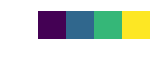

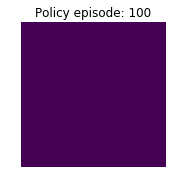

In [7]:
env = grid_world_v1()                                              # Environment instance with the first reward function.
max_eps = 100                                                      # Max number of episodes to train
max_steps = 100                                                    # Max number of steps per episode during training
exp_decay = 0.99                                                   # Exploration parameter decay
random = False                                                     # Flag to use random initial state

agent = our_Qlearning(num_states=64,num_actions=4,lr=0.5)          # Agent as instance of our_Qlearning class.

policies = run_Qlearning(env, agent, max_eps, max_steps, exp_decay, random) # Run the Qlearning algorithm

plot_policies(policies,(1,1))                         # Plot some policies (add (1,1) arg to plot only the last one)

### Test the agent 
#### (runs the learned policy for 1 episode of 20 steps max)

<IPython.core.display.Javascript object>


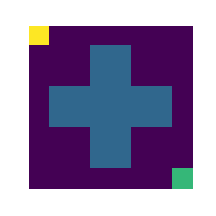

In [8]:
%matplotlib notebook

env = grid_world()                             # Creates a new instance of the environment (required for rendering).

for episode in range(30):                      # Loops over 30 episodes.
    state = env.reset(random)                  # Reset the environment.
    done = False                               # done flag starts as false.
    step = 1                                   # step counter starts in 1.
    while (not done and step < 20):            # Looping until terminal or during max steps.
        action = agent.greedy(state)           # Select action based on greedy policy.
        state,_,done = env.step(action)        # Take selected action.
        env.render()                           # Renders the current map of the environment.
        step += 1                              # Increase step counter by one.

%matplotlib inline

# Concluding remarks